In [5]:
%matplotlib inline
from __future__ import print_function

import sys
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

from hipopy import Event, LorentzVector, Particle, hipo_reader

SECTORS = 7
BEAM_E = 2.2
MASS_ELEC = 0.000511
MASS_P = 0.93827

def gaus(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def Q2_calc(_e_mu, _e_mu_prime):
    """Retruns Q^2: q^mu^2 = (e^mu - e^mu')^2 = -Q^2"""
    _q_mu = (_e_mu - _e_mu_prime)
    return -_q_mu.Mag2


def W_calc(_e_mu, _e_mu_prime):
    """Returns W: Gotten from s channel [(gamma + P)^2 == s == w^2]"""
    _q_mu = (_e_mu - _e_mu_prime)
    _p_target = LorentzVector(0.0, 0.0, 0.0, mass=0.93827)
    return (_p_target + _q_mu).Mag

In [2]:
def process(filenames):
    events = 0
    num = 0
    e_mu = LorentzVector(0.0, 0.0, BEAM_E, mass=MASS_ELEC)
    for f in filenames:
        reader = hipo_reader(f)
        while reader.next():
            events += 1

    print("Processing {} Events".format(events))
    start = time.time()
    W = np.ones(shape=(events+1)) * np.nan
    Q2 = np.ones(shape=(events+1)) * np.nan

    for f in filenames:
        reader = hipo_reader(f)
        data = Event(reader)
        for event in data:
            mm = LorentzVector(0.0, 0.0, 0.0, mass=MASS_P) 
            mm += e_mu
            num += 1
            e_mu_prime = event.particles[0].FourVector
            W[num] = W_calc(e_mu, e_mu_prime)
            Q2[num] = Q2_calc(e_mu, e_mu_prime)
        
    end = time.time()
    print((end - start), "Sec")
    print((events / (end - start)), "Hz")
    
    return W, Q2

In [3]:
W, Q2 = process(['/Users/tylern/Data/hipo/skim4_2549.hipo'])

Processing 1508417 Events
53.9994621277 Sec
27933.9263868 Hz


/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


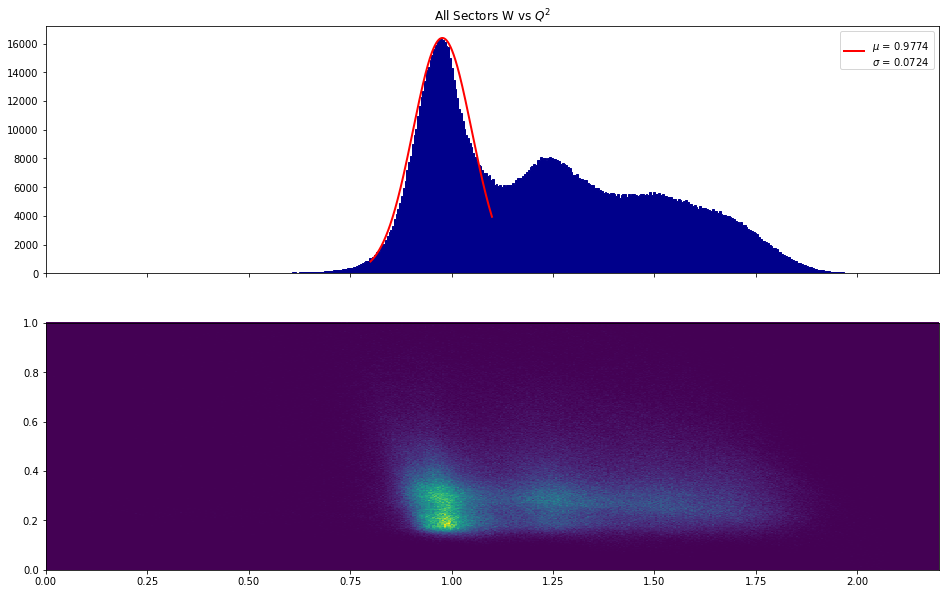

In [4]:
fig_WQ2, axs_WQ2 = plt.subplots(2, sharex='col', figsize=(16, 10))
W = W[~np.isnan(W)]
Q2 = Q2[~np.isnan(Q2)]
h, b, _ = axs_WQ2[0].hist(W, bins=500, range=(0.0, 2.2), color='darkblue',
                           histtype='step', fill=True)
y, bins = np.histogram(W, range=(0.8, 1.1), bins=500, density=True)
x = (bins[:-1] + bins[1:]) / 2
popt, pcov = curve_fit(gaus, x, y, p0=[1.0, 1.0, 1.0])
popt[0] = max(h)
axs_WQ2[0].plot(x, gaus(x, *popt), "red",
                 label="$\mu$ = {0:.4f}\n$\sigma$ = {1:.4f}".format(popt[1], popt[2]), linewidth=2)
axs_WQ2[0].legend()

axs_WQ2[1].hist2d(W, Q2, bins=500, range=((0.0, 2.2), (0, 1.0)))
axs_WQ2[0].set_title("All Sectors W vs $Q^2$")

fig_WQ2.show()